In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

Using TensorFlow backend


## Time to get your hands dirty. Galaxies vs quasars with neural networks.

Let's go back to our galaxy vs quasar data we've used in a previous exercise. 

1. Read in SDSS galaxy color data from `solutions/galaxyquasar.csv`. Create arrays for the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors. Also create an array with the class labels where galaxy=$0$ and quasar=$1$. 

2. Now we're going to fit a neural network classifier. First, scale your data appropriately and do a 30% train/test split.

3. Now train the classifier. Use one the package among those we've seen. These include Tensorflow via keras, pytorch, and the MPL classifier implemented in scikit-learn. This is an opportunity to pick the one you're most interested in learning. 

3. Start from a network architecture with a single hidden layer with 5 neurons, using the `adam` solver, the `relu` activation function, and a learninig rate of `0.001`. Plot the resulting ROC curve. 

4. Now let's optimize the hyperparameters of your network. Explore different hyperparameters and see what fits the data best.  Do your best now to optimize the network architecture. Be creative!

5. Is your best result comparable with the simpler classifiers we've seen before? Do we need deep learning here? If yes, which features are captured best?


A few tips:

- In scikit-learn, remember that you can utilize all availables cores on your machine with `n_jobs=-1`. Print out the classification score for the training data, and the best parameters obtained by the cross validation.
- If it takes too long, run the hyperparameter optimization on a subset of the training set. Then retrain the full network using the best hyperparameters only.
- On cross validation, for scikit learn we've seen how to use `GridSearchCV` already. For Tensorflow, there's a really cool tool called [Tensorboard](https://www.tensorflow.org/tensorboard)

# Code

## 1) Extracting data

Extract the fluxes

In [2]:
data = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', names=True, usecols=(0,1,2,3,4,6), dtype=float)
names = data.dtype.names
names

('u', 'g', 'r', 'i', 'z', 'z1')

In [3]:
data = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=(0,1,2,3,4,6), dtype=float)
data = dict(zip(names, data.T))
data

{'u': array([18.97213, 19.24592, 19.43536, ..., 18.62718, 19.5514 , 18.80772]),
 'g': array([18.53676, 17.47646, 17.70268, ..., 17.30876, 18.27711, 17.75751]),
 'r': array([18.5828 , 16.47817, 16.91565, ..., 16.87371, 17.62101, 17.405  ]),
 'i': array([18.34936, 16.04472, 16.58327, ..., 16.62399, 17.21947, 17.2165 ]),
 'z': array([18.29215, 15.68851, 16.39128, ..., 16.42296, 17.03347, 17.12295]),
 'z1': array([0.5228189 , 0.1228459 , 0.        , ..., 0.05442934, 0.1125709 ,
        0.04365238])}

Extract the labels

In [4]:
labels = np.genfromtxt('../solutions/galaxyquasar.csv', delimiter=',', skip_header=1, usecols=5, dtype=str)
print(f'labels: {labels}')
print(f'{np.sum(labels=="GALAXY")} galaxies')
print(f'{np.sum(labels=="QSO")} quasars')

le = LabelEncoder()
labels = le.fit_transform(labels)
class_names = le.classes_
print(f'\nencoded labels: {labels}')
print(f'class names:{class_names}')

labels: ['QSO' 'GALAXY' 'GALAXY' ... 'GALAXY' 'GALAXY' 'GALAXY']
42866 galaxies
7134 quasars

encoded labels: [1 0 0 ... 0 0 0]
class names:['GALAXY' 'QSO']


Create an array of the $(u-g)$, $(g-r)$, $(r-i)$, and $(i-z)$ colors

In [5]:
data['ug'] = data['u'] - data['g'] 
data['gr'] = data['g'] - data['r'] 
data['ri'] = data['r'] - data['i'] 
data['iz'] = data['i'] - data['z'] 
data['labels'] = labels
data.keys()

dict_keys(['u', 'g', 'r', 'i', 'z', 'z1', 'ug', 'gr', 'ri', 'iz', 'labels'])

## 2) Simple neural network

### 2.1) Training and test set

In [6]:
X = np.array([data['ug'], data['ri'], data['gr'], data['iz']]).T
y = data['labels']

In [7]:
normalizer = tf.keras.layers.Normalization(axis=1)
normalizer.adapt(X)

print(normalizer.mean.numpy())
print(np.sqrt(normalizer.variance.numpy()))

[[1.3107499  0.3431039  0.6306048  0.23080412]]
[[0.5467942  0.2164931  0.30958638 0.26311913]]


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=1)

### 2.2) Building the NN

In [9]:
learning_rate = 0.001                 
                                        
epochs = 100
                                        
loss_function = 'binary_crossentropy'   #https://keras.io/api/losses/                    
optimizer = tf.keras.optimizers.Adam    #https://keras.io/api/optimizers/

In [10]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,   
      tf.keras.layers.Dense(5, activation='relu'),   #https://keras.io/api/layers/activations/
      tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

  model.compile(optimizer=optimizer(learning_rate=learning_rate), 
                loss=loss_function,
                metrics=['accuracy'])
  
  return model

In [11]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 4)                 9         
 on)                                                             
                                                                 
 dense (Dense)               (None, 5)                 25        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 40 (164.00 Byte)
Trainable params: 31 (124.00 Byte)
Non-trainable params: 9 (40.00 Byte)
_________________________________________________________________


### 2.3) Train the model

In [12]:
%%time
history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    #batch_size = batch_size,
                    #verbose = 0,             #Suppress logging
                    validation_split = 0.2)   #Calculate validation results on 20% of the training data

Epoch 1/100
875/875 [==============================] - 1s 824us/step - loss: 0.3911 - accuracy: 0.9061 - val_loss: 0.1975 - val_accuracy: 0.9723
Epoch 2/100
875/875 [==============================] - 1s 693us/step - loss: 0.1384 - accuracy: 0.9763 - val_loss: 0.1113 - val_accuracy: 0.9813
Epoch 3/100
875/875 [==============================] - 1s 691us/step - loss: 0.0953 - accuracy: 0.9802 - val_loss: 0.0888 - val_accuracy: 0.9820
Epoch 4/100
875/875 [==============================] - 1s 674us/step - loss: 0.0842 - accuracy: 0.9818 - val_loss: 0.0821 - val_accuracy: 0.9817
Epoch 5/100
875/875 [==============================] - 1s 682us/step - loss: 0.0800 - accuracy: 0.9820 - val_loss: 0.0785 - val_accuracy: 0.9821
Epoch 6/100
875/875 [==============================] - 1s 659us/step - loss: 0.0777 - accuracy: 0.9821 - val_loss: 0.0765 - val_accuracy: 0.9820
Epoch 7/100
875/875 [==============================] - 1s 668us/step - loss: 0.0764 - accuracy: 0.9824 - val_loss: 0.0753 - val_ac

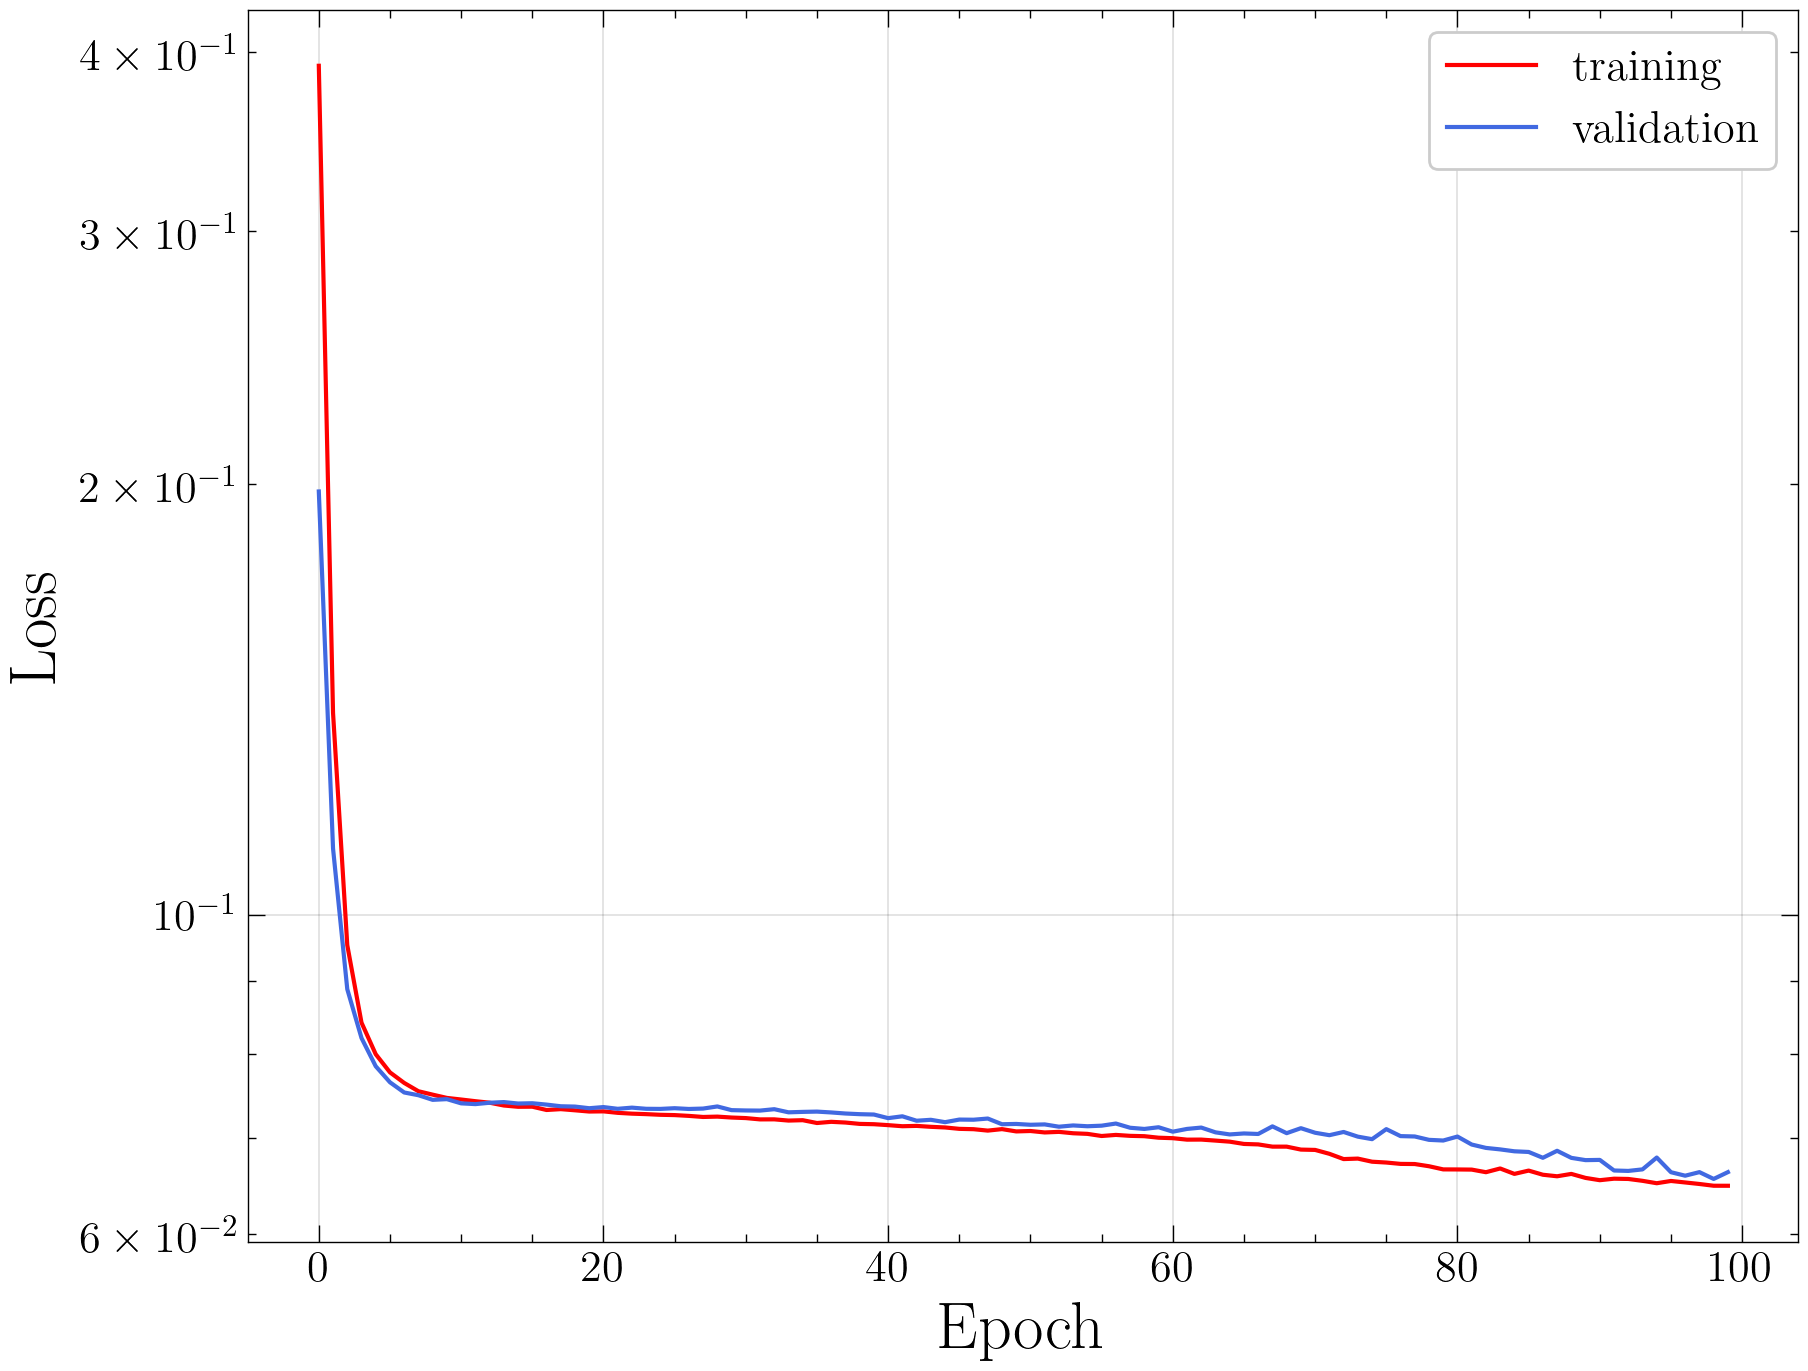

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], c='red', label='training')
    plt.plot(history.history['val_loss'], c='royalblue', label='validation')
    plt.yscale('log')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
plot_loss(history)

### 2.4) Test the model

In [14]:
test_results = model.evaluate(X_test, y_test, verbose=0)
test_results

[0.06676721572875977, 0.9829999804496765]

In [15]:
y_prob = np.squeeze(model.predict(X_test))
y_pred = (y_prob > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = np.sum(conf_matrix.diagonal())/len(y_test)
print(f'Accuracy      = {accuracy:.3f}')

completeness, contamination = completeness_contamination(y_pred, y_test)
print(f'Completeness  = {completeness}')
print(f'Contamination = {contamination}')

469/469 [==============================] - 0s 433us/step
Accuracy      = 0.983
Completeness  = 0.933456561922366
Contamination = 0.052088221492257156


### 2.5) ROC curves

In [16]:
def PlotROC(y_test, y_prob, y_pred):

    fig, axes = plt.subplots(1, 2, figsize=(14,8))

    # Compute the ROC curve and add (0, 0) as first point
    fpr, tpr, thresh1 = roc_curve(y_test, y_prob)
    fpr = np.concatenate([[0], fpr])
    tpr = np.concatenate([[0], tpr])

    # Compute the efficiency-completeness curve and add (1, 0) as first point
    precision, recall, thresh2 = precision_recall_curve(y_test, y_prob) 
    precision = np.concatenate([[0], precision])
    recall = np.concatenate([[1], recall])
    thresh2 = np.concatenate([[0], thresh2])

    ax = axes[0]
    ax.plot(fpr, tpr, c='red', lw=2)

    ax = axes[1]
    thresholds = np.linspace(0, 1, 1001)[:-1]
    comp = np.zeros_like(thresholds)
    cont = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        y_pred_temp = (y_prob >= t)
        comp[i], cont[i] = completeness_contamination(y_pred_temp, y_test)
    ax.plot(1 - cont, comp, c='red', lw=2)

    ax = axes[0]
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    ax = axes[1]
    ax.set_xlim(0)
    ax.set_ylim(0)
    ax.set_xlabel('Efficiency')
    ax.set_ylabel('Completeness')
    
    return fig, axes

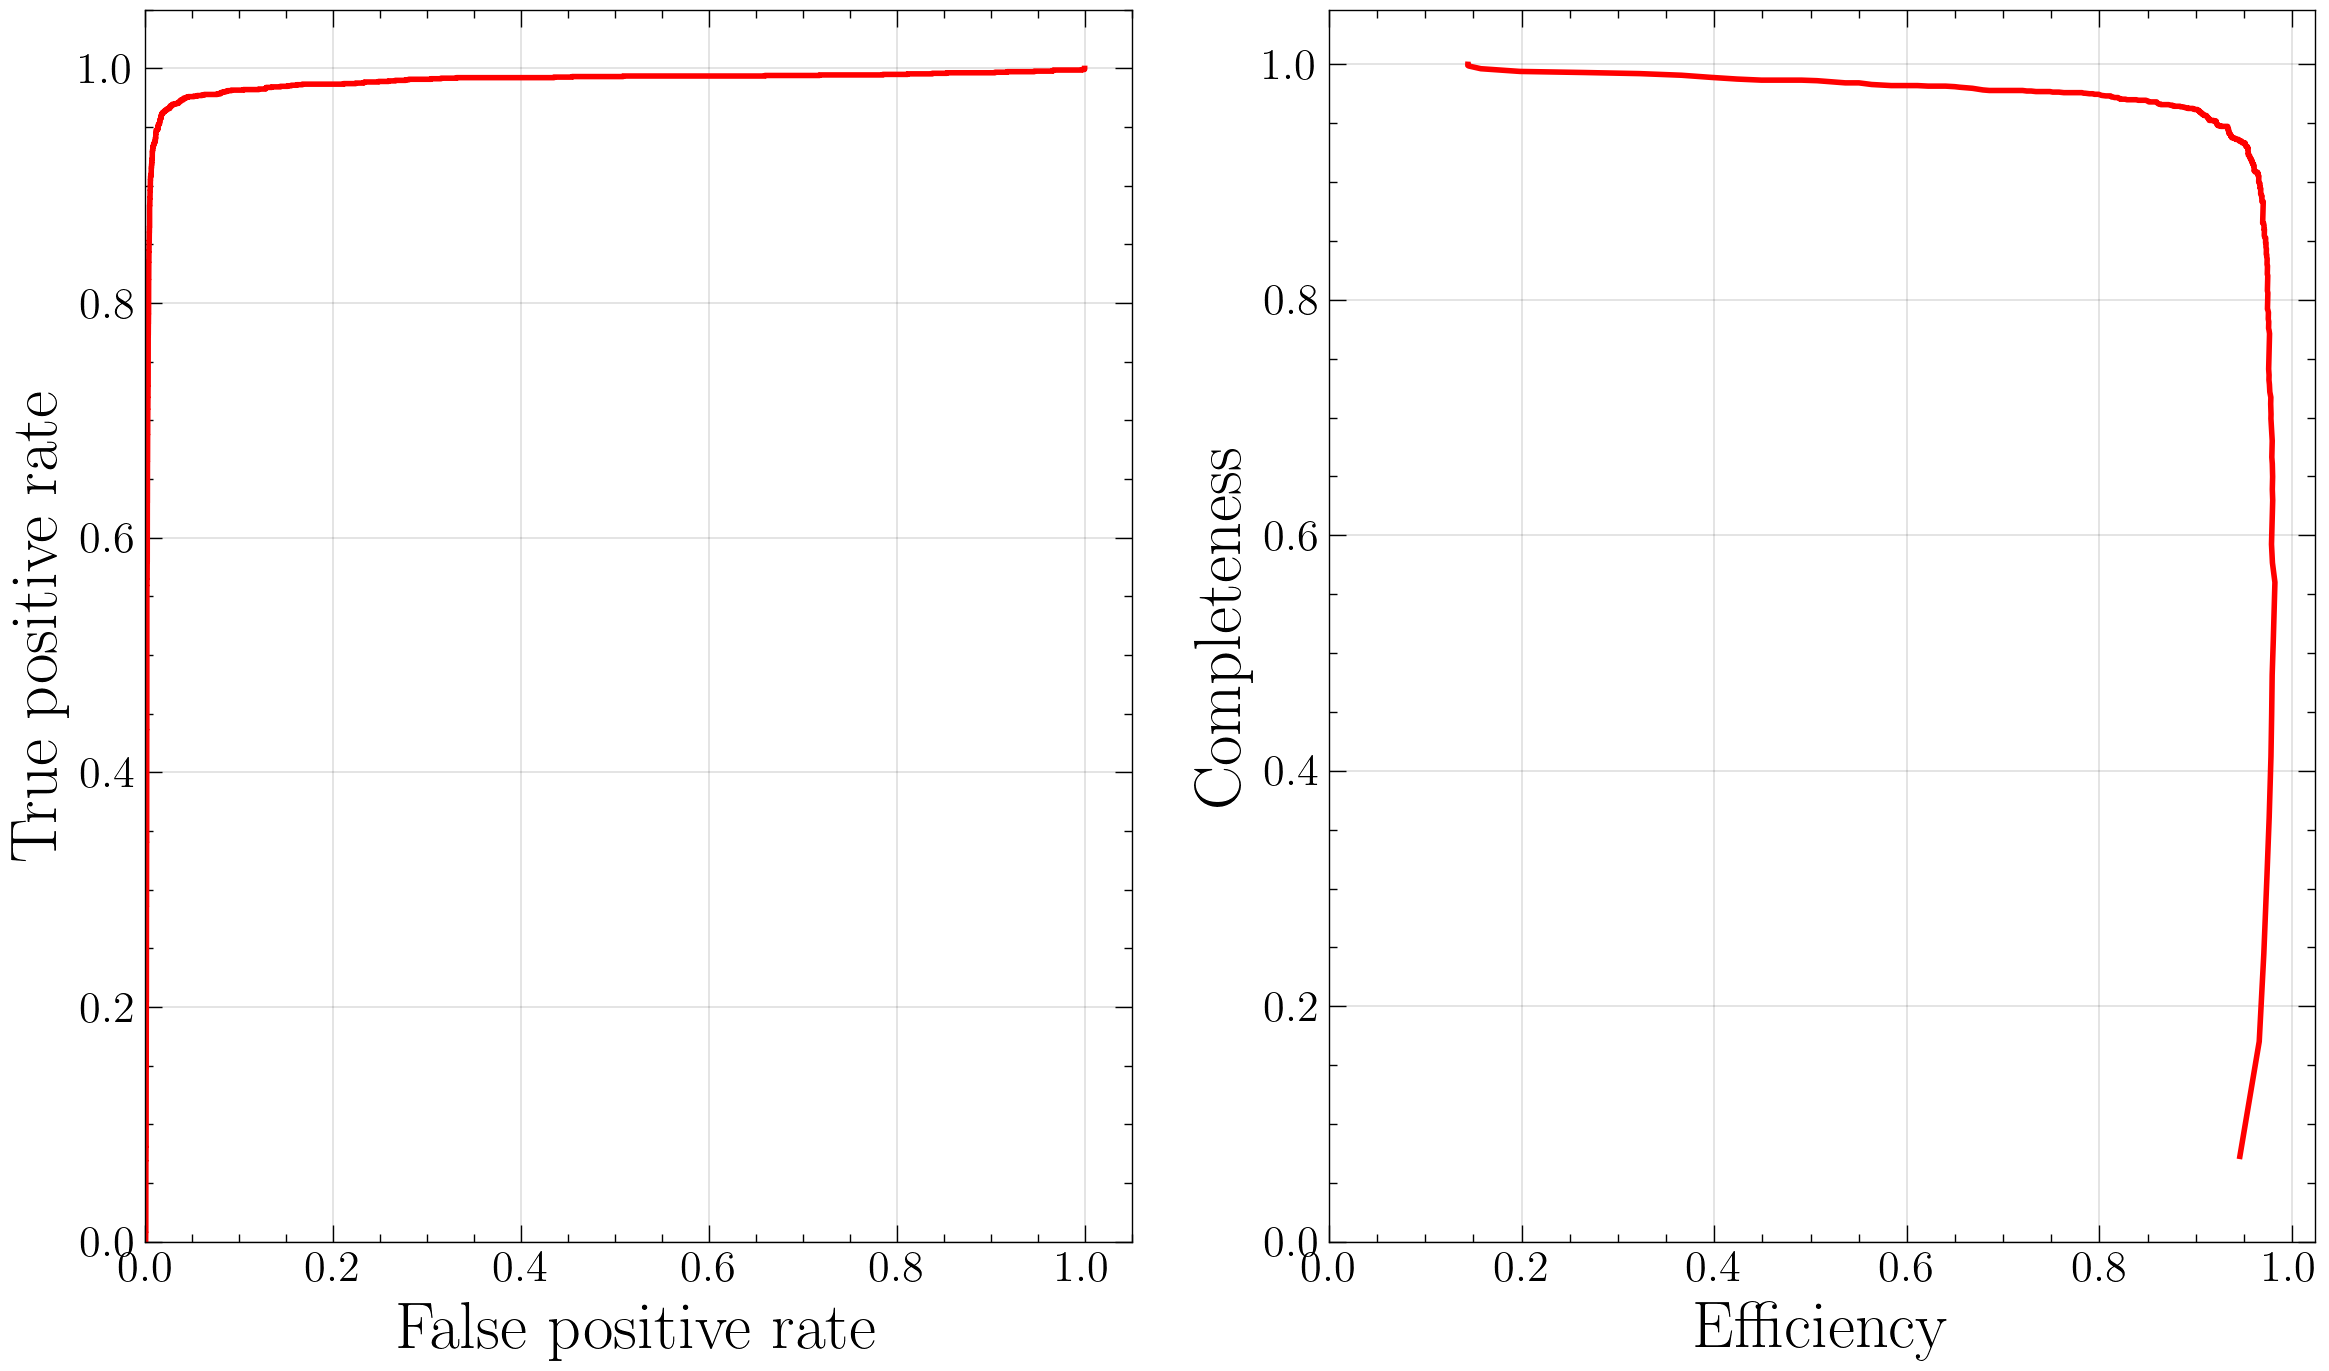

In [17]:
fig, axes = PlotROC(y_test, y_prob, y_pred)

## 3) Hyperparameter tuning

Let's try to optimize the number of nodes in the (two) layers and the learning rate.

In [34]:
learning_rate = 0.001                 
                                        
epochs = 100
batch_size = 32
                                        
loss_function = 'binary_crossentropy'   #https://keras.io/api/losses/                    
optimizer = tf.keras.optimizers.Adam    #https://keras.io/api/optimizers/

In [35]:
def build_and_compile_model(hp):
  
  # Tune the number of units in the hidden layers
  hp_units1 = hp.Int('units1', min_value=2, max_value=20, step=2)
  hp_units2 = hp.Int('units2', min_value=2, max_value=20, step=2)
  
  # Tune the learning rate for the optimizer
  hp_learning_rate = hp.Choice('learning_rate', values=[3e-3, 1e-3, 7e-4, 5e-4, 3e-4])
  
  model = tf.keras.Sequential([
      normalizer,                                               
      tf.keras.layers.Dense(units=hp_units1, activation='relu'), 
      tf.keras.layers.Dense(units=hp_units2, activation='relu'),   
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

  model.compile(optimizer=optimizer(learning_rate=hp_learning_rate), 
                loss=loss_function,
                metrics=['accuracy'])
  
  return model

In [36]:
# Instantiate the tuner and perform hypertuning
import os

tuner = kt.Hyperband(build_and_compile_model,
                     objective='val_loss',
                     max_epochs=100,
                     overwrite=True,
                     directory=os.path.normpath('C:/Users/Marco/Desktop')) 

In [37]:
tuner.search(
    X_train,
    y_train,
    epochs = epochs,
    batch_size = batch_size,              
    validation_split = 0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=10)]) #stops training if val_loss hasn't improved in the last 5 epochs

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 254 Complete [00h 00m 21s]
val_loss: 0.058145590126514435

Best val_loss So Far: 0.048493415117263794
Total elapsed time: 00h 22m 28s


In [38]:
tuner.results_summary()

Results summary
Results in C:\Users\Marco\Desktop\untitled_project
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0208 summary
Hyperparameters:
units1: 18
units2: 10
learning_rate: 0.003
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 0203
Score: 0.048493415117263794

Trial 0147 summary
Hyperparameters:
units1: 18
units2: 8
learning_rate: 0.003
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0144
Score: 0.0490451380610466

Trial 0228 summary
Hyperparameters:
units1: 18
units2: 20
learning_rate: 0.003
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0216
Score: 0.0493217408657074

Trial 0234 summary
Hyperparameters:
units1: 18
units2: 20
learning_rate: 0.003
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 0.04937911406159401

Trial 0142 summary
Hyperparameters:
units1: 16
units2: 16
le

## 4) Refined neural network

In [18]:
learning_rate = 0.003                 
                                        
epochs = 100
batch_size = 32
                                        
loss_function = 'binary_crossentropy'   #https://keras.io/api/losses/                    
optimizer = tf.keras.optimizers.Adam    #https://keras.io/api/optimizers/

In [19]:
# We reduce the learning rate as the epochs increase.
# The function is: 0.003 / (1 + step/30).
# The learning rate is equal to half of the initial value (i.e.=0.0015) after 30 epochs.
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  learning_rate,
  decay_steps=int(0.8*len(X_train)/batch_size)*30,
  decay_rate=1,
  staircase=False)

In [20]:
def build_and_compile_model(norm):
  model = tf.keras.Sequential([
      norm,   
      tf.keras.layers.Dense(18, activation='relu'),    #https://keras.io/api/layers/activations/
      tf.keras.layers.Dense(10, activation='relu'),   
      tf.keras.layers.Dense(1, activation='sigmoid') 
  ])

  model.compile(optimizer=optimizer(learning_rate=lr_schedule), 
                loss=loss_function,
                metrics=['accuracy'])
  
  return model

In [21]:
model = build_and_compile_model(normalizer)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 4)                 9         
 on)                                                             
                                                                 
 dense_2 (Dense)             (None, 18)                90        
                                                                 
 dense_3 (Dense)             (None, 10)                190       
                                                                 
 dense_4 (Dense)             (None, 1)                 11        
                                                                 
Total params: 300 (1.18 KB)
Trainable params: 291 (1.14 KB)
Non-trainable params: 9 (40.00 Byte)
_________________________________________________________________


In [22]:
%%time
history = model.fit(X_train,
                    y_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    #verbose = 0,             #Suppress logging
                    validation_split = 0.2)   #Calculate validation results on 20% of the training data

Epoch 1/100
875/875 [==============================] - 1s 780us/step - loss: 0.1122 - accuracy: 0.9746 - val_loss: 0.0711 - val_accuracy: 0.9834
Epoch 2/100
875/875 [==============================] - 1s 689us/step - loss: 0.0683 - accuracy: 0.9840 - val_loss: 0.0672 - val_accuracy: 0.9821
Epoch 3/100
875/875 [==============================] - 1s 691us/step - loss: 0.0663 - accuracy: 0.9840 - val_loss: 0.0598 - val_accuracy: 0.9840
Epoch 4/100
875/875 [==============================] - 1s 719us/step - loss: 0.0613 - accuracy: 0.9847 - val_loss: 0.0576 - val_accuracy: 0.9847
Epoch 5/100
875/875 [==============================] - 1s 713us/step - loss: 0.0613 - accuracy: 0.9843 - val_loss: 0.0544 - val_accuracy: 0.9853
Epoch 6/100
875/875 [==============================] - 1s 709us/step - loss: 0.0587 - accuracy: 0.9850 - val_loss: 0.0549 - val_accuracy: 0.9846
Epoch 7/100
875/875 [==============================] - 1s 720us/step - loss: 0.0580 - accuracy: 0.9843 - val_loss: 0.0541 - val_ac

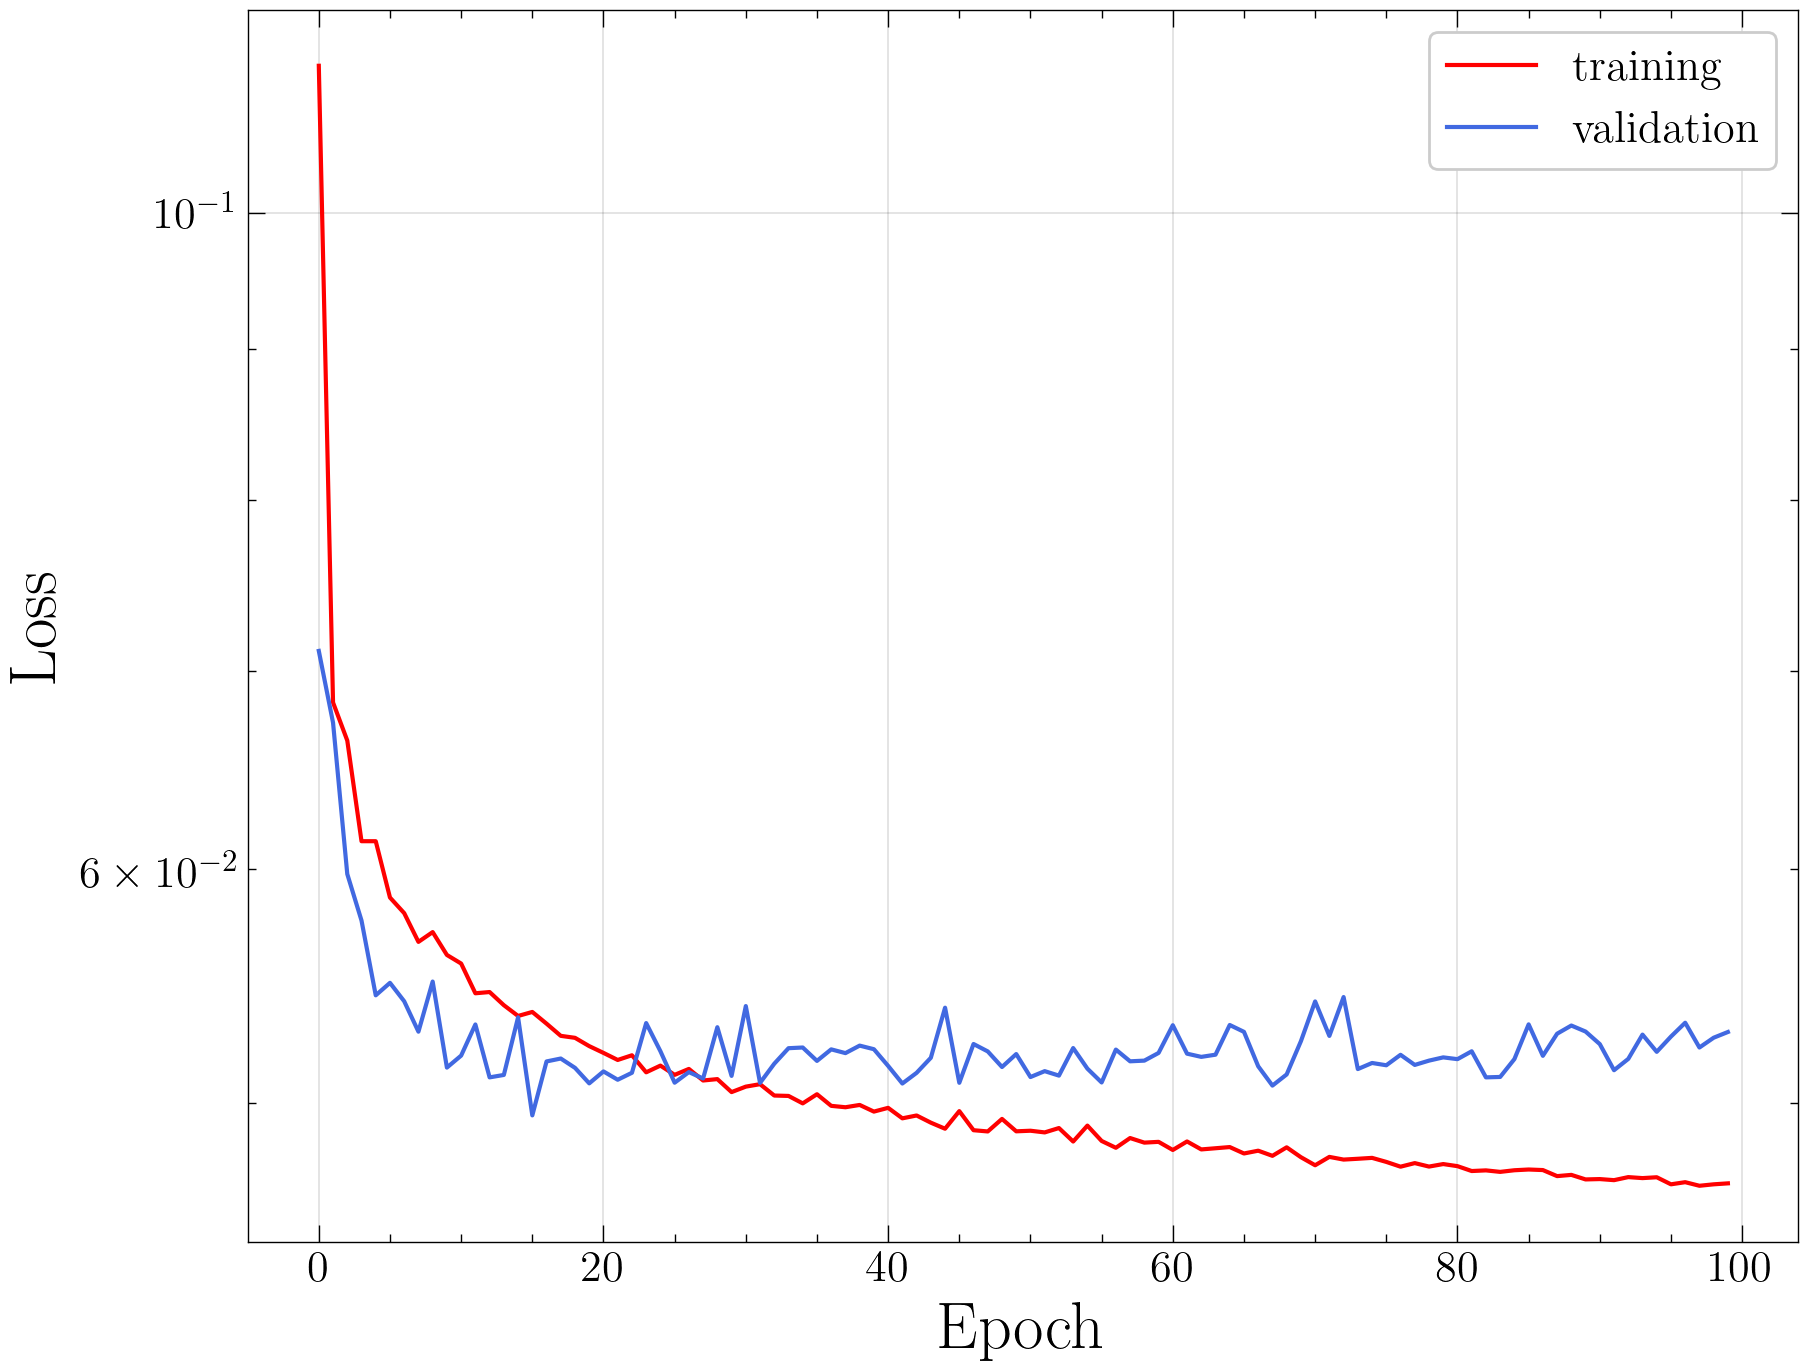

In [23]:
plot_loss(history)

In [24]:
test_results = model.evaluate(X_test, y_test, verbose=0)
test_results

[0.04849982634186745, 0.9866666793823242]

In [25]:
y_prob = np.squeeze(model.predict(X_test))
y_pred = (y_prob > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test, y_pred)
accuracy = np.sum(conf_matrix.diagonal())/len(y_test)
print(f'Accuracy      = {accuracy:.3f}')

completeness, contamination = completeness_contamination(y_pred, y_test)
print(f'Completeness  = {completeness:.3f}')
print(f'Contamination = {contamination:.3f}')

469/469 [==============================] - 0s 432us/step
Accuracy      = 0.987
Completeness  = 0.954
Contamination = 0.046


These results are comparable with the best `scikit-learn` generative-classification algorithm that we had used in the last exercise, i.e. `K-Nearest Neighbors`.

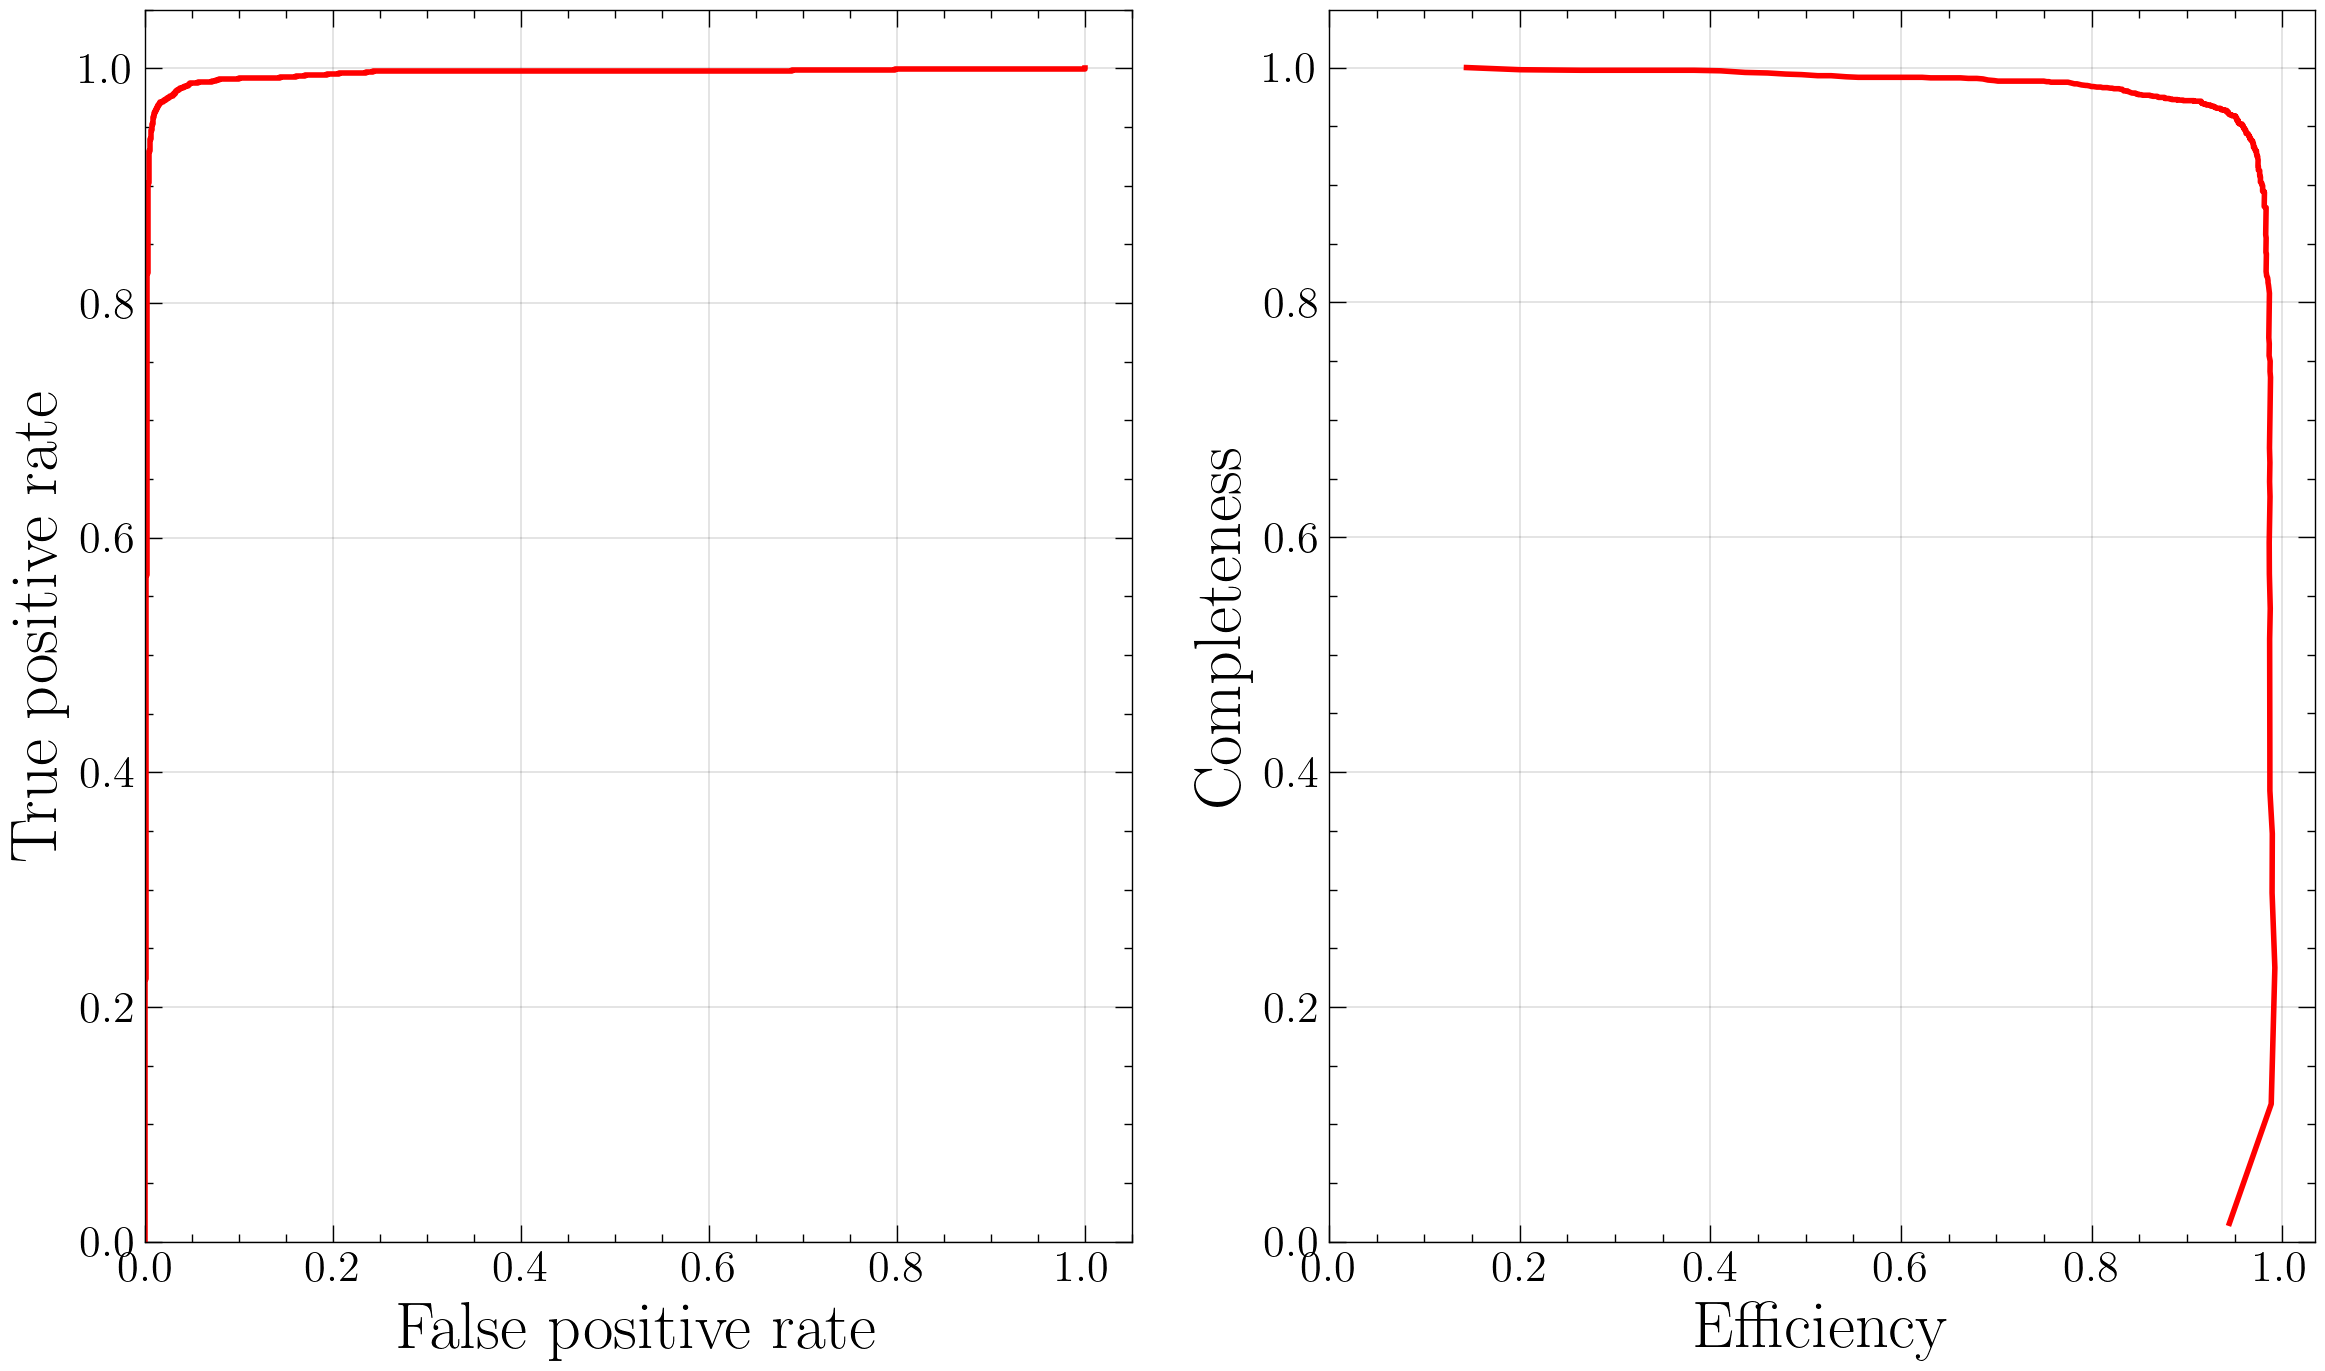

In [26]:
fig, axes = PlotROC(y_test, y_prob, y_pred)